In [26]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import PIL
import os
import random

In [3]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [6]:
case_types = {
    'akiec' : "Actinic keratoses and intraepithelial carcinoma / Bowen's disease", 
    'bcc': "basal cell carcinoma", 
    'bkl': "benign keratosis-like lesions (solar lentigines / seborrheic keratoses and lichen-planus like keratoses)",
    'df': "dermatofibroma", 
    'mel': "melanoma", 
    'nv': "melanocytic nevi",
    'vasc': "vascular lesions (angiomas, angiokeratomas, pyogenic granulomas and hemorrhage)"
}

In [8]:
classes = list(case_types.keys())
classes

['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']

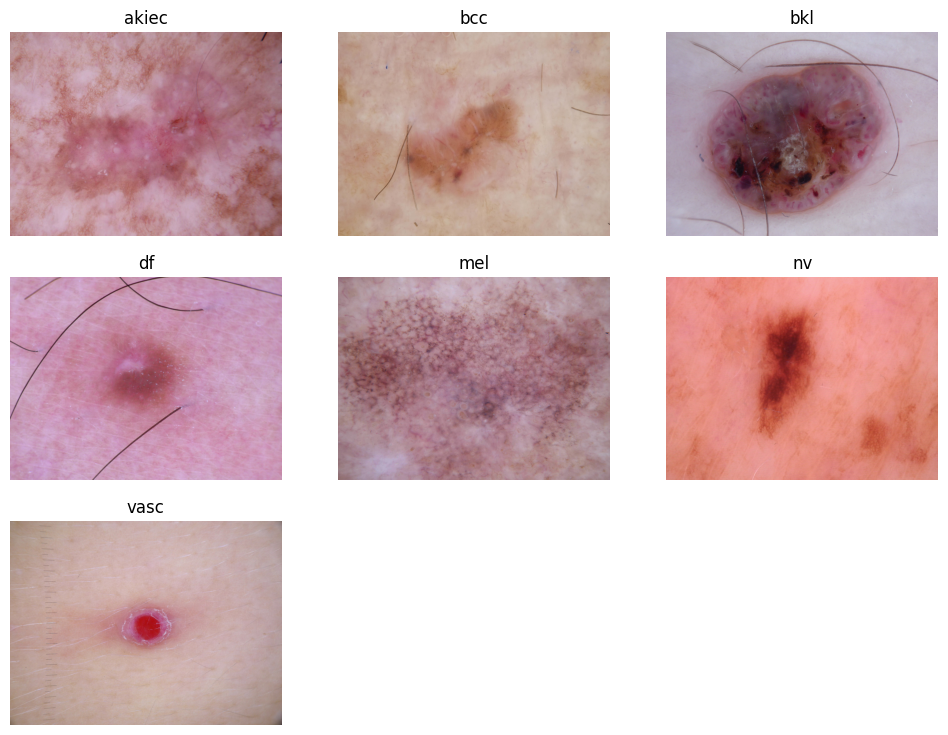

In [30]:
images_to_show = []

for cls in classes:
    dataset = list(os.listdir(f'ham_sample/{cls}'))
    images_to_show.append(f'ham_sample/{cls}/{dataset[random.randint(0,105)]}')
    
plt.figure(figsize=(12, 9))
for idx, image_path in enumerate(images_to_show):
    ax = plt.subplot(3, 3, idx + 1)
    image = mpimg.imread(image_path)
    plt.imshow(image)
    plt.title(classes[idx])
    plt.axis("off")


In [31]:
data_dir = 'ham_sample'
validation_split = 0.15
batch_size = 32
img_height = 150
img_width = 200
seed = 2024

train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=validation_split,
  subset="training",
  seed=seed,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=validation_split,
  subset="validation",
  seed=seed,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 805 files belonging to 7 classes.
Using 685 files for training.
Found 805 files belonging to 7 classes.
Using 120 files for validation.


In [39]:
class_names = train_ds.class_names
num_classes = len(class_names)
print(class_names)

['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']


In [41]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [88]:
data_preprocessing = keras.Sequential(
  [
    layers.RandomFlip(mode="horizontal_and_vertical",
                      input_shape=(img_height, img_width, 3)),
    layers.RandomRotation(0.5),
    layers.RandomZoom(0.2),
    layers.RandomBrightness(0.3),
    layers.Rescaling(1./255),
  ]
)

In [89]:
model = Sequential([
  data_preprocessing,
  layers.Conv2D(16, 3, padding='valid', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='valid', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='valid', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

In [90]:
lr = 0.00001

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [91]:
model.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_18 (Sequential)  (None, 150, 200, 3)       0         
                                                                 
 conv2d_30 (Conv2D)          (None, 148, 198, 16)      448       
                                                                 
 max_pooling2d_30 (MaxPoolin  (None, 74, 99, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_31 (Conv2D)          (None, 72, 97, 32)        4640      
                                                                 
 max_pooling2d_31 (MaxPoolin  (None, 36, 48, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_32 (Conv2D)          (None, 34, 46, 64)      

In [92]:
epochs = 10

history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
22/22 [==============================] - 10s 357ms/step - loss: 2.8106 - accuracy: 0.1328 - val_loss: 1.9464 - val_accuracy: 0.1750
Epoch 2/10
22/22 [==============================] - 8s 343ms/step - loss: 1.9481 - accuracy: 0.1226 - val_loss: 1.9489 - val_accuracy: 0.1167
Epoch 3/10
22/22 [==============================] - 8s 355ms/step - loss: 1.9477 - accuracy: 0.1080 - val_loss: 1.9475 - val_accuracy: 0.1167
Epoch 4/10
22/22 [==============================] - 8s 349ms/step - loss: 1.9468 - accuracy: 0.1431 - val_loss: 1.9485 - val_accuracy: 0.1167
Epoch 5/10
22/22 [==============================] - 7s 341ms/step - loss: 1.9464 - accuracy: 0.1474 - val_loss: 1.9485 - val_accuracy: 0.1167
Epoch 6/10
22/22 [==============================] - 8s 348ms/step - loss: 1.9467 - accuracy: 0.1474 - val_loss: 1.9482 - val_accuracy: 0.1167
Epoch 7/10
22/22 [==============================] - 8s 348ms/step - loss: 1.9469 - accuracy: 0.1270 - val_loss: 1.9471 - val_accuracy: 0.1167
Epoch

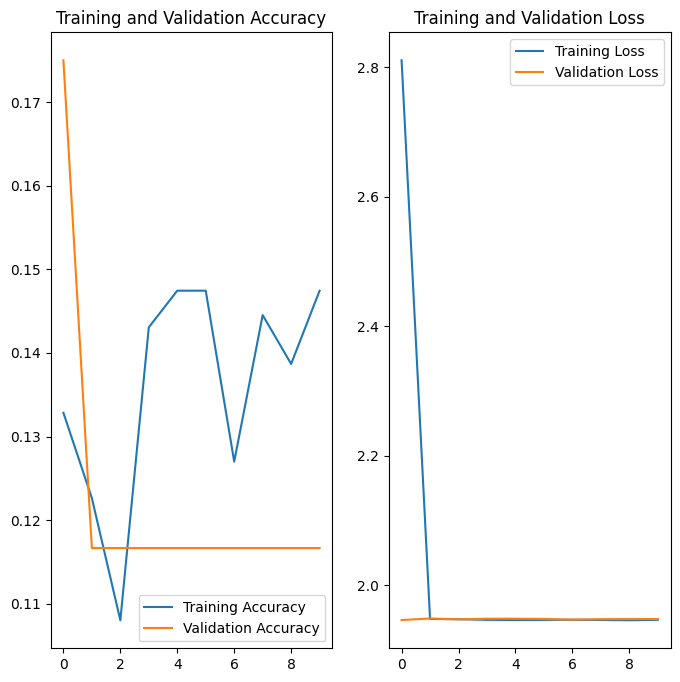

In [93]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
# results are really bad in fact